In [7]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Turn off RDKit warnings
RDLogger.DisableLog('rdApp.*')

# Loading data
df = pd.read_csv("tox21.csv")

# Toxic Task List
task_columns = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER',
    'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5',
    'SR-HSE', 'SR-MMP', 'SR-p53'
]

In [9]:
# SMILES to ECFP4 fingerprint
def smiles_to_ecfp4(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)

# Generate fingerprints
fingerprints = []
valid_indices = []
for i, s in tqdm(enumerate(df["smiles"]), total=len(df)):
    fp = smiles_to_ecfp4(s)
    if fp is not None:
        fingerprints.append(fp)
        valid_indices.append(i)

X = np.array([np.array(fp) for fp in fingerprints])
df_valid = df.iloc[valid_indices].reset_index(drop=True)

print("Number of valid samples:", len(X))


100%|██████████| 8006/8006 [00:01<00:00, 4021.78it/s]


Number of valid samples: 8006


NR-AR           Validation AUC: 0.8324
NR-AR           Test AUC: 0.7294
NR-AR-LBD       Validation AUC: 0.9489
NR-AR-LBD       Test AUC: 0.8124
NR-AhR          Validation AUC: 0.8906
NR-AhR          Test AUC: 0.8991
NR-Aromatase    Validation AUC: 0.7965
NR-Aromatase    Test AUC: 0.8001
NR-ER           Validation AUC: 0.6995
NR-ER           Test AUC: 0.6998
NR-ER-LBD       Validation AUC: 0.7654
NR-ER-LBD       Test AUC: 0.7817
NR-PPAR-gamma   Validation AUC: 0.7742
NR-PPAR-gamma   Test AUC: 0.8126
SR-ARE          Validation AUC: 0.8087
SR-ARE          Test AUC: 0.8294
SR-ATAD5        Validation AUC: 0.8025
SR-ATAD5        Test AUC: 0.8245
SR-HSE          Validation AUC: 0.7842
SR-HSE          Test AUC: 0.7934
SR-MMP          Validation AUC: 0.8927
SR-MMP          Test AUC: 0.8465
SR-p53          Validation AUC: 0.8044
SR-p53          Test AUC: 0.8451


C:\Users\17538\AppData\Local\Temp\ipykernel_19340\4113988682.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=tasks, palette="rocket")


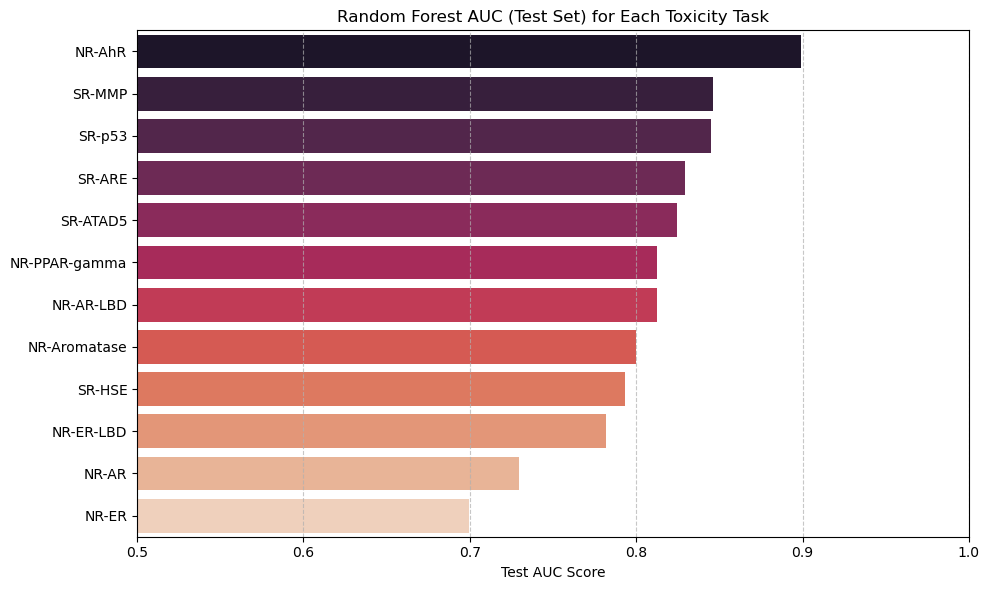

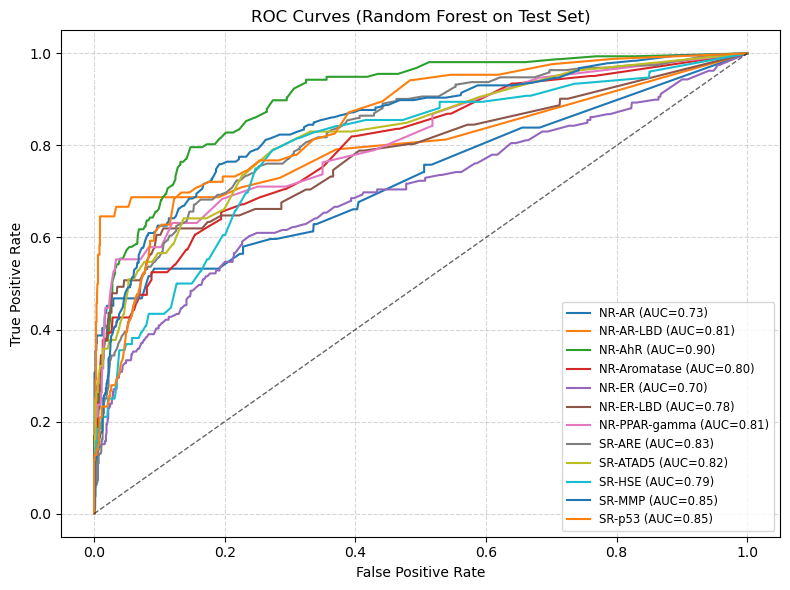


Mean Test AUC: 0.8061
Median Test AUC: 0.8125


In [10]:
def evaluate_rf_with_3splits_and_roc(X, df_valid, task_columns):
    aucs = {}
    roc_info_list = []

    for task in task_columns:
        y = df_valid[task]
        mask = ~y.isna()
        X_task = X[mask]
        y_task = y[mask]

        if sum(y_task == 1) < 10 or sum(y_task == 0) < 10:
            print(f"[Skipped] {task} - not enough positive/negative samples")
            continue

        # Split out the test set (20%)
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_task, y_task, test_size=0.2, random_state=42, stratify=y_task
        )

        # From the remaining data, split training and validation (20% of 80% = 16%)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
        )

        # Train the Random Forest model
        model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        # Evaluate on validation set
        val_pred = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, val_pred)
        print(f"{task:15s} Validation AUC: {val_auc:.4f}")

        #  Evaluate on test set and compute ROC
        y_pred = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred)
        aucs[task] = auc_score

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_info_list.append((task, fpr, tpr, auc_score))

        print(f"{task:15s} Test AUC: {auc_score:.4f}")

    # Barplot of AUC scores on test set
    sorted_aucs = dict(sorted(aucs.items(), key=lambda x: x[1], reverse=True))
    tasks = list(sorted_aucs.keys())
    scores = list(sorted_aucs.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=scores, y=tasks, palette="rocket")
    plt.xlabel("Test AUC Score")
    plt.title("Random Forest AUC (Test Set) for Each Toxicity Task")
    plt.xlim(0.5, 1.0)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # ROC curves
    plt.figure(figsize=(8, 6))
    for task, fpr, tpr, auc_score in roc_info_list:
        plt.plot(fpr, tpr, label=f'{task} (AUC={auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Random Forest on Test Set)")
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Overall metrics
    mean_auc = np.mean(scores)
    median_auc = np.median(scores)
    print(f"\nMean Test AUC: {mean_auc:.4f}")
    print(f"Median Test AUC: {median_auc:.4f}")

    return aucs


rf_aucs = evaluate_rf_with_3splits_and_roc(X, df_valid, task_columns)

NR-AR           Validation AUC: 0.8324
NR-AR           Test AUC: 0.6868
NR-AR-LBD       Validation AUC: 0.9236
NR-AR-LBD       Test AUC: 0.8284
NR-AhR          Validation AUC: 0.8815
NR-AhR          Test AUC: 0.8621
NR-Aromatase    Validation AUC: 0.7658
NR-Aromatase    Test AUC: 0.8027
NR-ER           Validation AUC: 0.6920
NR-ER           Test AUC: 0.6792
NR-ER-LBD       Validation AUC: 0.7245
NR-ER-LBD       Test AUC: 0.7644
NR-PPAR-gamma   Validation AUC: 0.7376
NR-PPAR-gamma   Test AUC: 0.7249
SR-ARE          Validation AUC: 0.8013
SR-ARE          Test AUC: 0.7784
SR-ATAD5        Validation AUC: 0.7699
SR-ATAD5        Test AUC: 0.7969
SR-HSE          Validation AUC: 0.7864
SR-HSE          Test AUC: 0.7195
SR-MMP          Validation AUC: 0.8694
SR-MMP          Test AUC: 0.8333
SR-p53          Validation AUC: 0.7845
SR-p53          Test AUC: 0.8372


C:\Users\17538\AppData\Local\Temp\ipykernel_19340\3033932943.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=tasks, palette="viridis")


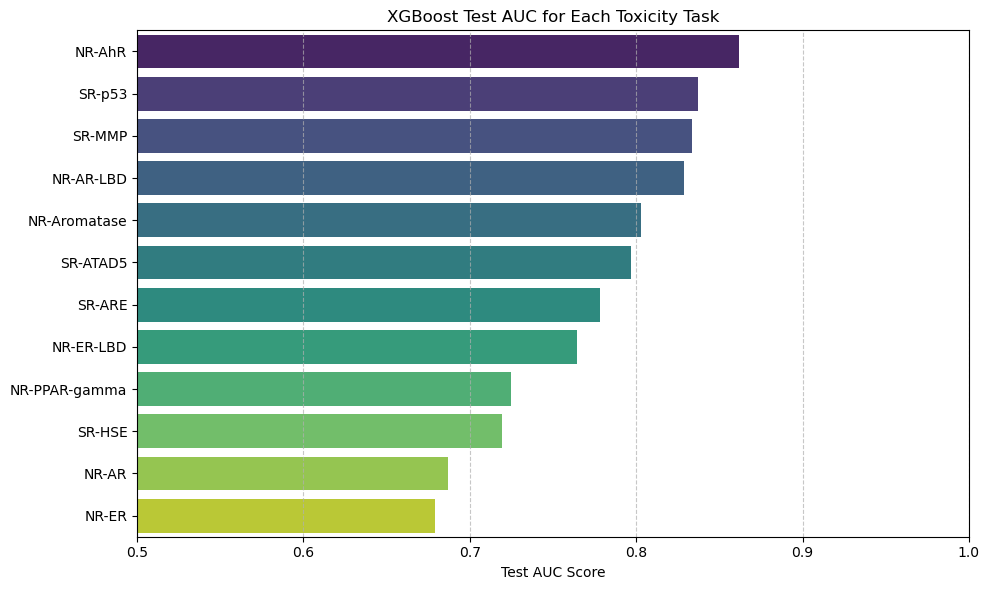

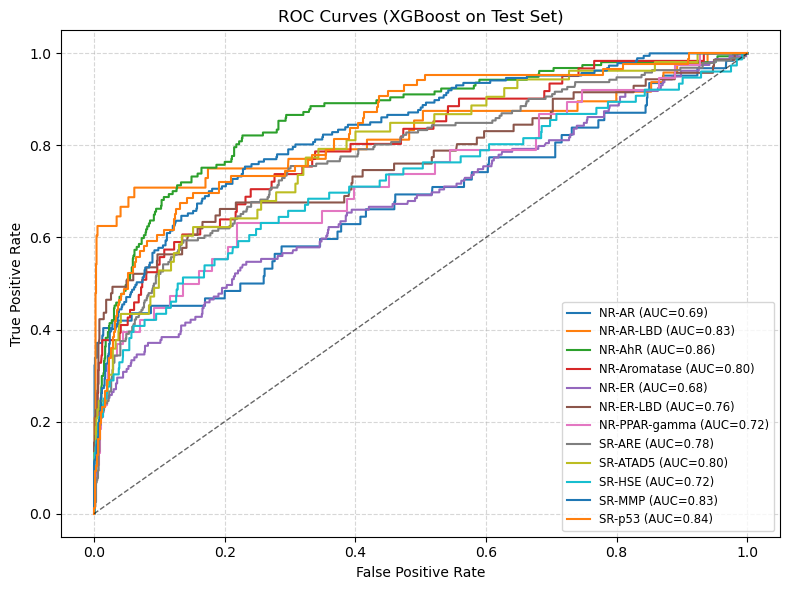


Mean Test AUC: 0.7761
Median Test AUC: 0.7876


In [11]:
from xgboost import XGBClassifier


def evaluate_xgb_with_3splits_and_roc(X, df_valid, task_columns):
    aucs = {}
    roc_info_list = []

    for task in task_columns:
        y = df_valid[task]
        mask = ~y.isna()
        X_task = X[mask]
        y_task = y[mask]

        # Skip tasks with too few positive/negative samples
        if sum(y_task == 1) < 10 or sum(y_task == 0) < 10:
            print(f"[Skipped] {task} - not enough positive/negative samples")
            continue

        #  Split out the test set (20%)
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_task, y_task, test_size=0.2, random_state=42, stratify=y_task
        )

        #  From the remaining data, split training and validation (20% of 80% = 16%)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
        )

        # Train the XGBoost model
        model = XGBClassifier(
            n_estimators=200,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
            verbosity=0,
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        # Evaluate on validation set
        val_pred = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, val_pred)
        print(f"{task:15s} Validation AUC: {val_auc:.4f}")

        # Evaluate on test set and compute ROC
        y_pred = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_pred)
        aucs[task] = test_auc

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_info_list.append((task, fpr, tpr, test_auc))

        print(f"{task:15s} Test AUC: {test_auc:.4f}")

    # Barplot of AUC scores on test set
    sorted_aucs = dict(sorted(aucs.items(), key=lambda x: x[1], reverse=True))
    tasks = list(sorted_aucs.keys())
    scores = list(sorted_aucs.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=scores, y=tasks, palette="viridis")
    plt.xlabel("Test AUC Score")
    plt.title("XGBoost Test AUC for Each Toxicity Task")
    plt.xlim(0.5, 1.0)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # ROC curves
    plt.figure(figsize=(8, 6))
    for task, fpr, tpr, auc_score in roc_info_list:
        plt.plot(fpr, tpr, label=f'{task} (AUC={auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (XGBoost on Test Set)")
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Overall metrics
    mean_auc = np.mean(scores)
    median_auc = np.median(scores)
    print(f"\nMean Test AUC: {mean_auc:.4f}")
    print(f"Median Test AUC: {median_auc:.4f}")

    return aucs

# Run the evaluation
xgb_aucs = evaluate_xgb_with_3splits_and_roc(X, df_valid, task_columns)
